In [1]:
require 'loadcaffe'
require 'image'

-- Converts an image from RGB to BGR format and subtracts mean
function preprocess(im, img_mean)
  -- rescale the image
  local im3 = image.scale(im,224,224,'bilinear')*255
  -- RGB2BGR
  local im4 = im3:clone()
  im4[{1,{},{}}] = im3[{3,{},{}}]
  im4[{3,{},{}}] = im3[{1,{},{}}]

  -- subtract imagenet mean
  return im4 - image.scale(img_mean, 224, 224, 'bilinear')
end

-- Setting up networks 

prototxt_name = '/usr/local/data/CaffeZoo/caffenet-yos/deploy.prototxt'
binary_name = '/usr/local/data/CaffeZoo/caffenet-yos/caffenet-yos-weights'

--prototxt_name = '/usr/local/data/CaffeZoo/bvlc_alexnet/deploy.prototxt'
--binary_name = '/usr/local/data/CaffeZoo/bvlc_alexnet/bvlc_alexnet.caffemodel'

print '==> Loading network'

net = loadcaffe.load(prototxt_name, binary_name, 'cudnn')

-- as we want to classify, let's disable dropouts by enabling evaluation mode
net:evaluate()

print '==> Loading image and imagenet mean'
image_name = 'Goldfish3.jpg'
--image_name = 'continuum_of_coverage_general_surveillance_5.jpg'
img_mean_name = 'ilsvrc_2012_mean.t7'

im = image.load(image_name)
img_mean = torch.load(img_mean_name).img_mean:transpose(3,1)

-- Have to resize and convert from RGB to BGR and subtract mean
print '==> Preprocessing'
I = preprocess(im, img_mean)

==> Loading network	


Successfully loaded /usr/local/data/CaffeZoo/caffenet-yos/caffenet-yos-weights


MODULE data UNDEFINED
module 'data' not found


conv1: 96 3 11 11


conv2: 256 48 5 5


conv3: 384 256 3 3


conv4: 384 192 3 3


conv5: 256 192 3 3


fc6: 1 1 9216 4096


fc7: 1 1 4096 4096


fc8: 1 1 4096 1000


==> Loading image and imagenet mean	


==> Preprocessing	


# Deconvolve feature maps from layer 1

==> Time elapsed: 0.080717086791992 seconds	
==> Deconv1 Feature Maps	

 96
 54
 54
[torch.LongStorage of size 3]



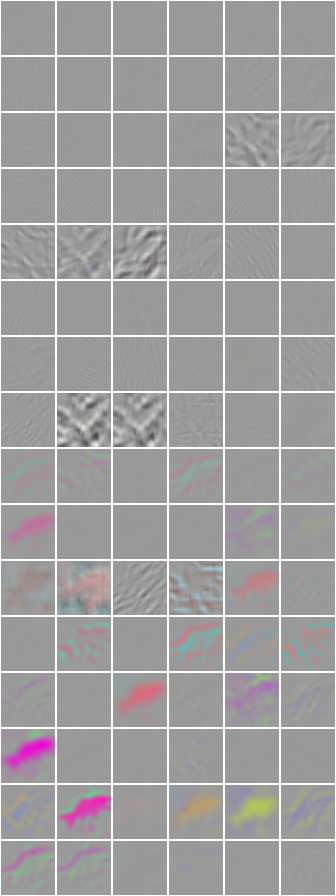

In [2]:
conv1 = net:get(1)
conv1_fm = conv1:forward(I:cuda())

timer = torch.Timer()

deconv1_fm = torch.Tensor(96, 3, conv1_fm:size(2), conv1_fm:size(3)):cuda()
deconv1 = cudnn.SpatialConvolution(1, 1, 11, 11, 1, 1, 5, 5):cuda()


for i=1,96 do
    for j=1,3 do
        fm = conv1_fm[i]
        
        deconv1.weight = conv1.weight[{ {i}, {j}, {}, {} }]:transpose(3, 4):contiguous()
        deconv_result = deconv1:forward(fm:view(1, conv1_fm:size(2), conv1_fm:size(3)))
        -- BGR to RGB    
        deconv1_fm[{ {i}, {3-(j-1)}, {}, {} }] = deconv_result
    end
end

cutorch.synchronize()
print('==> Time elapsed: ' .. timer:time().real .. ' seconds')

print '==> Deconv1 Feature Maps'
print(conv1_fm:size())
itorch.image(deconv1_fm:float())

#Create "Switches" table

In [3]:
conv1 = net:get(1)
conv1_fm = conv1:forward(I:cuda())


switches_1={}

local stride_size = 2
local kernel_size = 3

timer = torch.Timer()

conv1_fm_p = nn.SpatialZeroPadding(0, stride_size-1, 0, stride_size-1 ):forward(conv1_fm:cuda()) --right and bottom padding 2

for i=1,96 do
    local x=1
    local counter =1
    switches_1[i]={}
    while x<=conv1_fm:size(2) do
        local y=1
        while y<=conv1_fm:size(3) do
            local x_ub = x+kernel_size-1
            local y_ub = y+kernel_size-1
            if x_ub > conv1_fm:size(2) then
                x_ub = conv1_fm:size(2)
            end
            
            if y_ub > conv1_fm:size(3) then
                y_ub = conv1_fm:size(3)
            end          
                
            local max_kernel = conv1_fm_p[{{i},{x,x_ub},{y,y_ub}}]            
            max_col,idx_col=torch.max(max_kernel[1],2)
            max_val,idx_row=torch.max(max_col,1)
            switches_1[i][counter] = { max_row=x-1+idx_row[1][1], 
                                       max_col=y-1+idx_col[idx_row[1][1]][1] }
            counter = counter + 1    
            y=y+stride_size
        end
        
        x=x+stride_size
    end
end

cutorch.synchronize()
print('==> Time elapsed: ' .. timer:time().real .. ' seconds')
--print(switches_1[1][1].max_row)

==> Time elapsed: 0.81436085700989 seconds	


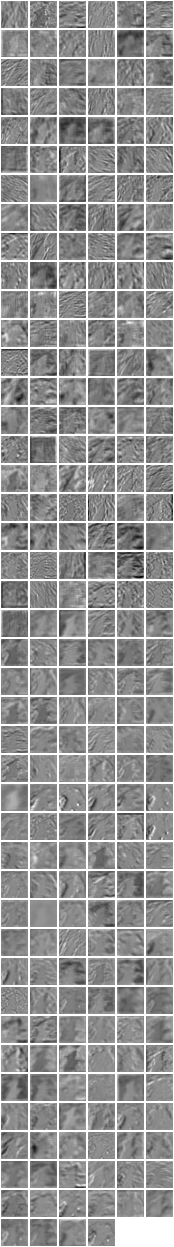

In [4]:
conv2 = nn.Sequential()
conv2:add(net:get(1))
conv2:add(net:get(2)) --relu
conv2:add(net:get(3)) --pooling
conv2:add(net:get(4)) --normalize
conv2:add(net:get(5))
conv2_fm = conv2:forward(I:cuda())

itorch.image(conv2_fm)

#Deconvolve the feature map from layer 2

==> Time elapsed: 2.2722918987274 seconds	


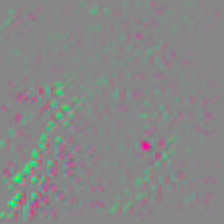

In [5]:
conv2 = nn.Sequential()
conv2:add(net:get(1))
conv2:add(net:get(2)) --relu
conv2:add(net:get(3)) --pooling
conv2:add(net:get(4)) --normalize
conv2:add(net:get(5))
conv2_fm = conv2:forward(I:cuda())

timer = torch.Timer()

--group2 deconv

idx_conv2_fm = 249
--print(conv2_fm:float()[idx_conv2_fm]:size())
itorch.image(conv2_fm:float()[idx_conv2_fm])

deconv2_fm_for1 = torch.CudaTensor( 48, conv2_fm:size(2), conv2_fm:size(3)):cuda()
deconv2 = cudnn.SpatialConvolution(1, 1, 5, 5, 1, 1, 2, 2):cuda()

for j=1,48 do
    fm = conv2_fm[idx_conv2_fm]

    deconv2.weight = conv2:get(5).weight[{ {idx_conv2_fm}, {j}, {}, {} }]:transpose(3, 4):contiguous():cuda()
    deconv2_result = deconv2:forward(fm:view(1,27,27))
    deconv2_fm_for1[{{j},{},{}}]=deconv2_result
end

--group2 unpool1 

local fm_idx1 = 1
if idx_conv2_fm > 128 then
     fm_idx1 = 49 
end

unpool1_fm_for1 = torch.CudaTensor( 48, conv1_fm:size(2), conv1_fm:size(3)):zero():cuda()

local row=1
local col=1
-- for j in pairs(switches_1[fm_idx1]) do
--     switches_1[fm_idx1][j].max_row
-- end
for i=1,48 do
    local row=1
    local col=1
    for j in pairs(switches_1[fm_idx1]) do
        unpool1_fm_for1[i][switches_1[fm_idx1][j].max_row][switches_1[fm_idx1][j].max_col] = deconv2_fm_for1[i][row][col]
        if col+1<=deconv2_fm_for1:size(3) then
            col = col +1
        else
            col = 1
            row = row + 1
        end
    end
end    

-- --Scatter feature map

unpool1_scat_fm_for1 = torch.CudaTensor(48, I:size(2), I:size(3)):zero():cuda()
local stride_size = 4
local padding_size = (I:size(2) - (conv1_fm:size(2) * stride_size))/2

for i=1,48 do
    local scat_x=padding_size+1
    for j=1,conv1_fm:size(2) do
        local scat_y=padding_size+1
        for k=1,conv1_fm:size(3) do
            unpool1_scat_fm_for1[i][scat_x][scat_y]=unpool1_fm_for1[i][j][k]
            scat_y = scat_y + stride_size
        end
        
        scat_x = scat_x + stride_size
    end
end

--group2 deconv1 

deconv1_fm_for1 = torch.CudaTensor( 3, 224, 224):cuda()
deconv1 = cudnn.SpatialConvolution(48, 1, 11, 11, 1, 1, 5, 5):cuda()

for j=1,3 do

    deconv1.weight = conv1.weight[{ {fm_idx1, fm_idx1+47}, {j}, {}, {} }]:transpose(3, 4):contiguous()
    deconv_result = deconv1:forward(unpool1_scat_fm_for1:cuda())

    -- BGR to RGB    
    deconv1_fm_for1[{ {3-(j-1)}, {}, {} }] = deconv_result
end


cutorch.synchronize()
print('==> Time elapsed: ' .. timer:time().real .. ' seconds')
-- print(unpool1_scat_fm_for1:size())
-- itorch.image(unpool1_fm_for1:float())
-- itorch.image(unpool1_scat_fm_for1:float())
itorch.image(deconv1_fm_for1:float())

#Unpool and Deconvolve the feature map from layer 2

==> Time elapsed: 2.384966135025 seconds	


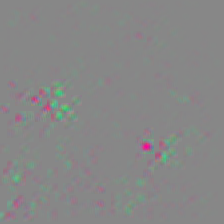

In [6]:
conv2 = nn.Sequential()
conv2:add(net:get(1))
conv2:add(net:get(2)) --relu
conv2:add(net:get(3)) --pooling
conv2:add(net:get(4)) --normalize
conv2:add(net:get(5))
conv2_fm = conv2:forward(I:cuda())

timer = torch.Timer()

idx_conv2_fm = 249
--print(conv2_fm:float()[idx_conv2_fm]:size())
itorch.image(conv2_fm:float()[idx_conv2_fm])


--unpool the feature map
local stride_size = 2
local kernel_size = 3

conv2_fm_p = nn.SpatialZeroPadding(0, stride_size, 0, stride_size ):forward(conv2_fm:cuda())
conv2_fm_for1_p = conv2_fm_p[idx_conv2_fm]
unpool2_fm_for1 = torch.CudaTensor( conv2_fm:size(2), conv2_fm:size(3) ):zero():cuda()

local x=1
while x<=conv2_fm:size(2) do
    local y=1
    while y<=conv2_fm:size(3) do
        local x_ub = x+kernel_size-1
        local y_ub = y+kernel_size-1
        if x_ub > conv2_fm:size(2) then
            x_ub = conv2_fm:size(2)
        end

        if y_ub > conv2_fm:size(3) then
            y_ub = conv2_fm:size(3)
        end          

        local max_kernel = conv2_fm_for1_p[{{x,x_ub},{y,y_ub}}]   
        max_col,idx_col=torch.max(max_kernel,2)
        max_val,idx_row=torch.max(max_col,1)
        unpool2_fm_for1[x-1+idx_row[1][1]][y-1+idx_col[idx_row[1][1]][1]]=max_val

        y=y+stride_size
    end

    x=x+stride_size
end

itorch.image(unpool2_fm_for1)

--group2 deconv
deconv2_fm_for1 = torch.CudaTensor( 48, conv2_fm:size(2), conv2_fm:size(3)):cuda()
deconv2 = cudnn.SpatialConvolution(1, 1, 5, 5, 1, 1, 2, 2):cuda()

for j=1,48 do
    fm = unpool2_fm_for1

    deconv2.weight = conv2:get(5).weight[{ {idx_conv2_fm}, {j}, {}, {} }]:transpose(3, 4):contiguous():cuda()
    deconv2_result = deconv2:forward(fm:view(1,27,27))
    deconv2_fm_for1[{{j},{},{}}]=deconv2_result
end

--group2 unpool1 

local fm_idx1 = 1
if idx_conv2_fm > 128 then
     fm_idx1 = 49 
end

unpool1_fm_for1 = torch.CudaTensor( 48, conv1_fm:size(2), conv1_fm:size(3)):zero():cuda()

local row=1
local col=1
-- for j in pairs(switches_1[fm_idx1]) do
--     switches_1[fm_idx1][j].max_row
-- end
for i=1,48 do
    local row=1
    local col=1
    for j in pairs(switches_1[fm_idx1]) do
        unpool1_fm_for1[i][switches_1[fm_idx1][j].max_row][switches_1[fm_idx1][j].max_col] = deconv2_fm_for1[i][row][col]
        if col+1<=deconv2_fm_for1:size(3) then
            col = col +1
        else
            col = 1
            row = row + 1
        end
    end
end    

-- --Scatter feature map

unpool1_scat_fm_for1 = torch.CudaTensor(48, I:size(2), I:size(3)):zero():cuda()
local stride_size = 4
local padding_size = (I:size(2) - (conv1_fm:size(2) * stride_size))/2

for i=1,48 do
    local scat_x=padding_size+1
    for j=1,conv1_fm:size(2) do
        local scat_y=padding_size+1
        for k=1,conv1_fm:size(3) do
            unpool1_scat_fm_for1[i][scat_x][scat_y]=unpool1_fm_for1[i][j][k]
            scat_y = scat_y + stride_size
        end
        
        scat_x = scat_x + stride_size
    end
end

--group2 deconv1 

deconv1_fm_for1 = torch.CudaTensor( 3, 224, 224):cuda()
deconv1 = cudnn.SpatialConvolution(48, 1, 11, 11, 1, 1, 5, 5):cuda()

for j=1,3 do

    deconv1.weight = conv1.weight[{ {fm_idx1, fm_idx1+47}, {j}, {}, {} }]:transpose(3, 4):contiguous()
    deconv_result = deconv1:forward(unpool1_scat_fm_for1:cuda())

    -- BGR to RGB    
    deconv1_fm_for1[{ {3-(j-1)}, {}, {} }] = deconv_result
end


cutorch.synchronize()
print('==> Time elapsed: ' .. timer:time().real .. ' seconds')
-- print(unpool1_scat_fm_for1:size())
-- itorch.image(unpool1_fm_for1:float())
-- itorch.image(unpool1_scat_fm_for1:float())
itorch.image(deconv1_fm_for1:float())